## Prepare the Data

In [43]:
import pandas as pd

### Load Data

Load the data and filter out the columns we don't need.

In [44]:
df = pd.read_csv('data/constructed-output-data.csv', encoding='utf-8')
df = df.filter(items=['shadow', 'latitude', 'longitude', 
                      'feb_state_temp', 'feb_region_temp',
                      'mar_state_temp', 'mar_region_temp'])
df

,shadow,latitude,longitude,feb_state_temp,feb_region_temp,mar_state_temp,mar_region_temp
0,Full Shadow,41.6219,-72.7273,18.7,15.6,31.5,27.6
1,Full Shadow,38.9896,-75.5050,24.2,15.6,39.5,27.6
2,Full Shadow,45.3695,-69.2428,11.8,15.6,21.3,27.6
3,Full Shadow,39.0550,-76.7909,23.6,15.6,39.3,27.6
4,Full Shadow,42.2596,-71.8083,18.5,15.6,30.8,27.6
...,...,...,...,...,...,...,...
2767,Full Shadow,44.6243,-89.9941,13.5,12.6,25.7,26.3
2768,Full Shadow,42.0751,-93.4960,24.8,19.7,40.3,34.5
2769,Full Shadow,44.3467,-85.4102,23.6,19.7,35.0,34.5
2770,Full Shadow,46.2807,-94.3053,14.0,19.7,30.4,34.5


### Understand Our Data

Let's take a look at our data.

In [45]:
df.shadow.value_counts()

Full Shadow    2443
No Shadow       329
Name: shadow, dtype: int64

In [46]:
df.shadow.value_counts(normalize=True)

Full Shadow    0.881313
No Shadow      0.118687
Name: shadow, dtype: float64

array([[<AxesSubplot:title={'center':'latitude'}>,
        <AxesSubplot:title={'center':'longitude'}>],
       [<AxesSubplot:title={'center':'feb_state_temp'}>,
        <AxesSubplot:title={'center':'feb_region_temp'}>],
       [<AxesSubplot:title={'center':'mar_state_temp'}>,
        <AxesSubplot:title={'center':'mar_region_temp'}>]], dtype=object)

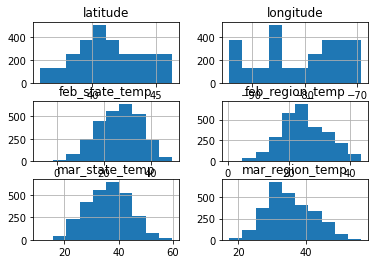

In [47]:
df.hist()

shadow
Full Shadow    [[AxesSubplot(0.125,0.670278;0.336957x0.209722...
No Shadow      [[AxesSubplot(0.125,0.670278;0.336957x0.209722...
dtype: object

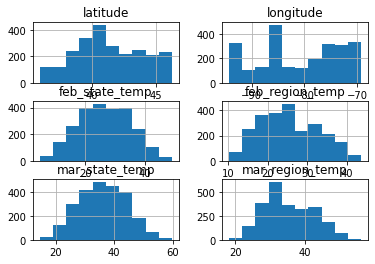

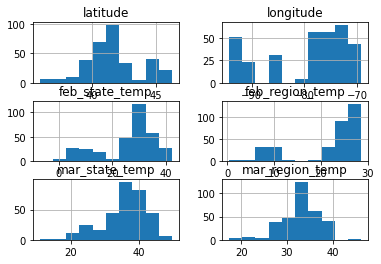

In [48]:
df.groupby('shadow').hist()

### Targets & Features

Get the values for the target and the features.

In [49]:
df_target = df.iloc[:, 0]
df_features = df.iloc[:, 1:].astype(float)

X, y = df_features.values, df_target.values

In [50]:
X.shape, y.shape

((2772, 6), (2772,))

### Balancing Our Data

Our data is way out of balance. Balance it to improve the results of our model.

In [51]:
from imblearn.over_sampling import RandomOverSampler

In [52]:
oversampler = RandomOverSampler(sampling_strategy='minority')
X_over, y_over = oversampler.fit_resample(X, y)

In [53]:
X_over.shape, y_over.shape

((4886, 6), (4886,))

## Build Some Models

In [54]:
models = []

### Train/Test Split

Split the training and testing data 80/20.

In [55]:
from sklearn.model_selection import train_test_split

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, train_size=0.80, test_size=0.20, random_state=0)

In [57]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3908, 6), (978, 6), (3908,), (978,))

### Train a Support Vector Machine

In [58]:
from sklearn.svm import LinearSVC

In [59]:
svm = LinearSVC(dual=False, random_state=0).fit(X_train, y_train)

In [60]:
score = svm.score(X_test, y_test)
models.append((score, 'Support Vector Machine', svm))
score

0.7259713701431493

### Train a Logistic Regresion

In [61]:
from sklearn.linear_model import LogisticRegression

In [62]:
lr = LogisticRegression(solver='lbfgs', multi_class='ovr', random_state=0).fit(X_train, y_train)

In [63]:
score = lr.score(X_test, y_test)
models.append((score, 'Logistic Regression', lr))
score

0.7249488752556237

### Train a Random Forest

In [64]:
from sklearn.ensemble import RandomForestClassifier

In [65]:
rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0).fit(X_train, y_train)

In [66]:
score = rf.score(X_test, y_test)
models.append((score, 'Random Forest', rf))
score

0.9427402862985685

### Train a KNN Classifier

In [67]:
from sklearn.neighbors import KNeighborsClassifier

In [68]:
knn = KNeighborsClassifier(n_neighbors=3).fit(X_train, y_train)

In [69]:
score = knn.score(X_test, y_test)
models.append((score, 'K-Nearest Neighbors', knn))
score

0.950920245398773

### Select a Model

Select the model with the highest score.

In [70]:
models.sort(reverse=True)
models

[(0.950920245398773,
  'K-Nearest Neighbors',
  KNeighborsClassifier(n_neighbors=3)),
 (0.9427402862985685,
  'Random Forest',
  RandomForestClassifier(max_depth=5, random_state=0)),
 (0.7259713701431493,
  'Support Vector Machine',
  LinearSVC(dual=False, random_state=0)),
 (0.7249488752556237,
  'Logistic Regression',
  LogisticRegression(multi_class='ovr', random_state=0))]

In [71]:
model = models[0][2]
model

KNeighborsClassifier(n_neighbors=3)

## Save the Model

In [74]:
import pickle

In [75]:
with open('model/model.pickel', 'wb') as file:
  pickle.dump(model, file)